# グラフニューラルネットワーク入門ーGCNの実装
**GPU使用！！**

## Googleドライブをマウントしてパッケージをインストール



In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
dir_name = "Python/GNN"  # 好きなパスを設定してください
package_path = "/content/drive/MyDrive/" + dir_name + "/packages/"

In [3]:
# インストールにかかる時間は30分以上
# !pip install --no-cache-dir torch-geometric torch-sparse torch-scatter -t $package_path

In [4]:
import sys

sys.path.append(package_path)  

## １．ノード分類
大学の空手クラブのデータセット、「Karate club」を読み込みます。  
ノードは各メンバーを、エッジは交友関係を表します。  
空手クラブはトラブルによりいくつかのグループに分裂したのですが、各メンバーには所属する分裂後のグループを表すラベル（0, 1, 2，3）が付いています。 
特徴量は会員番号をone-hotベクトルで定義したものです。

### データセットの読み込み

In [9]:
from torch_geometric.datasets import KarateClub # 1分程度

dataset = KarateClub()
data = dataset[0]  

### グラフの情報を表示

In [13]:
def graph_info(data):

  print(f'ノードの数: {data.num_nodes}')
  print(f'エッジの数: {data.num_edges}')
  print(f'特徴量の数: {data.num_node_features}')
  print(f'クラス数: {dataset.num_classes}')

  print()

  print(f'無向グラフか？: {data.is_undirected()}')
  print(f'孤立したノードがあるか？: {data.has_isolated_nodes()}')
  print(f'自己ループがあるか？: {data.has_self_loops()}')

  print()

  print(f'キー: {data.keys}')
  print('各ノードの特徴量')
  print(data['x'])
  print('各ノードのラベル')
  print(data['y'])
  print('各エッジ')
  print(data['edge_index'])

In [14]:
graph_info(data)

ノードの数: 34
エッジの数: 156
特徴量の数: 34
クラス数: 4

無向グラフか？: True
孤立したノードがあるか？: False
自己ループがあるか？: False

キー: ['x', 'train_mask', 'y', 'edge_index']
各ノードの特徴量
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
各ノードのラベル
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
各エッジ
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25

In [15]:
print(f'ラベル付き（訓練用の）ノードの数: {data.train_mask.sum()}')
print(f'ラベル率: {int(data.train_mask.sum()) / data.num_nodes * 100:.2f} %')

ラベル付き（訓練用の）ノードの数: 4
ラベル率: 11.76 %


各クラス20個のノードにラベルが付いている．

In [32]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False], device='cuda:0')

In [34]:
import operator
bool_values = data.train_mask
negate_bool = map(operator.not_, bool_values)
data.test_mask = list(negate_bool)
data.test_mask = torch.tensor(data.test_mask)
data.test_mask

tensor([False,  True,  True,  True, False,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True])

In [35]:
print(f'テスト用のノードの数: {data.test_mask.sum()}')

テスト用のノードの数: 30


テスト用のノードはラベルが付いていないノードのうち，1000個のノードである．

### グラフの可視化

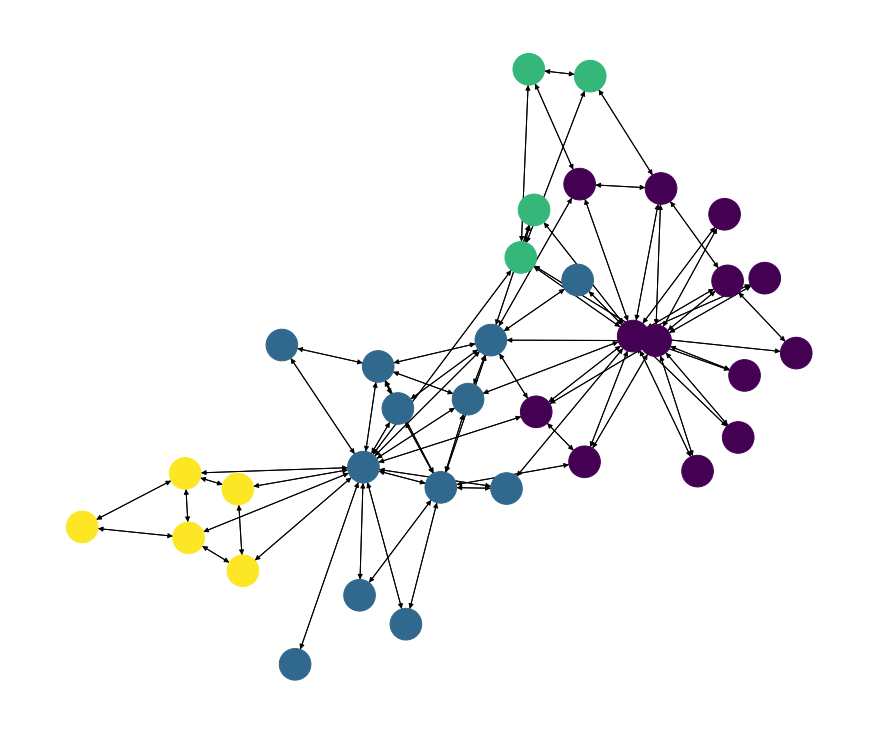

In [18]:
from torch_geometric.utils import to_networkx 
import networkx as nx
import matplotlib.pyplot as plt

data_nx = to_networkx(data)  # networkxのグラフに変換

plt.figure(figsize=(12, 10))
nx.draw(data_nx,
        node_color = data.y,
        node_size=1000)
plt.show()

### モデルの構築
GCNモデルを構築する．  
GNN層で畳み込みを行う．   
```
GCNConv(入力の特徴量数, 出力の特徴量数)
```  
https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv  
GNN層（チャンネル数1433→32）→ReLU関数→ドロップアウト（50%）→GNN層（チャンネル数32→7）  
特徴行列は入力2708×1433→GNN層→2708×32→・・・→GNN層→出力2708×7

In [19]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv 

hidden_channels = 32  # 中間層のチャンネル数

class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels) # チャンネル数を入力の1433から32に
        self.relu = nn.ReLU()  # ReLU（活性化関数が無いと非線形性が生じず，特徴量をうまく抽出できなくなる）
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes) # チャンネル数を32からノードのクラス数の7に

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index

        x = self.conv1(x, edge_index) # GCNは隣接するノードの情報を使うので，接続関係の情報edge_indexも渡す
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)

        return x

model = GCN()
model.cuda()  #GPU対応

GCN(
  (conv1): GCNConv(34, 32)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(32, 4)
)

### 学習
訓練データを使ってモデルを訓練する．  
訓練データを一度に全て使ってパラメータを更新するバッチ学習を行い，エポック数は200とする．    
勾配降下法の最適化アルゴリズムはAdam．

In [20]:
from torch import optim

data = data.cuda()  # GPU対応

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters())

model.train()  # 訓練モード
for epoch in range(1, 201):
    optimizer.zero_grad()  # ①勾配の初期化
    out = model(data)  # ②順伝播により予測値を得る
    loss = loss_fnc(out[data.train_mask], data.y[data.train_mask])  # ③予測値と正解値から損失関数の値を計算
    loss.backward()  # ④誤差から誤差逆伝播法により勾配を計算
    optimizer.step()  # ⑤最適化アルゴリズムによりパラメータを更新
    print(f'エポック: {epoch:03d}, 損失関数の値: {loss:.4f}')

エポック: 001, 損失関数の値: 1.3874
エポック: 002, 損失関数の値: 1.3870
エポック: 003, 損失関数の値: 1.3710
エポック: 004, 損失関数の値: 1.3765
エポック: 005, 損失関数の値: 1.3838
エポック: 006, 損失関数の値: 1.3896
エポック: 007, 損失関数の値: 1.3916
エポック: 008, 損失関数の値: 1.3696
エポック: 009, 損失関数の値: 1.3705
エポック: 010, 損失関数の値: 1.3693
エポック: 011, 損失関数の値: 1.3454
エポック: 012, 損失関数の値: 1.3703
エポック: 013, 損失関数の値: 1.3604
エポック: 014, 損失関数の値: 1.3628
エポック: 015, 損失関数の値: 1.3559
エポック: 016, 損失関数の値: 1.3559
エポック: 017, 損失関数の値: 1.3527
エポック: 018, 損失関数の値: 1.3480
エポック: 019, 損失関数の値: 1.3438
エポック: 020, 損失関数の値: 1.3574
エポック: 021, 損失関数の値: 1.3223
エポック: 022, 損失関数の値: 1.3323
エポック: 023, 損失関数の値: 1.3291
エポック: 024, 損失関数の値: 1.3545
エポック: 025, 損失関数の値: 1.3258
エポック: 026, 損失関数の値: 1.2876
エポック: 027, 損失関数の値: 1.3251
エポック: 028, 損失関数の値: 1.3141
エポック: 029, 損失関数の値: 1.3168
エポック: 030, 損失関数の値: 1.3103
エポック: 031, 損失関数の値: 1.3097
エポック: 032, 損失関数の値: 1.2921
エポック: 033, 損失関数の値: 1.3040
エポック: 034, 損失関数の値: 1.2741
エポック: 035, 損失関数の値: 1.2829
エポック: 036, 損失関数の値: 1.3140
エポック: 037, 損失関数の値: 1.2715
エポック: 038, 損失関数の値: 1.2723
エポック: 039, 損

### 評価
テスト用の（ラベルが付いていない）1000個のノードを使って精度を測定し，モデルを評価する．

In [36]:
model.eval()  # 評価モード
pred = model(data).argmax(dim=1) # 最も確率の高いクラスに分類する
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
accuracy = int(correct) / int(data.test_mask.sum())
print(f'正解率: {str(accuracy*100)} %') 

正解率: 86.66666666666667 %


混同行列で可視化してみる．

              precision    recall  f1-score   support

           0      0.833     0.833     0.833        12
           1      1.000     0.909     0.952        11
           2      0.500     0.667     0.571         3
           3      1.000     1.000     1.000         4

    accuracy                          0.867        30
   macro avg      0.833     0.852     0.839        30
weighted avg      0.883     0.867     0.873        30



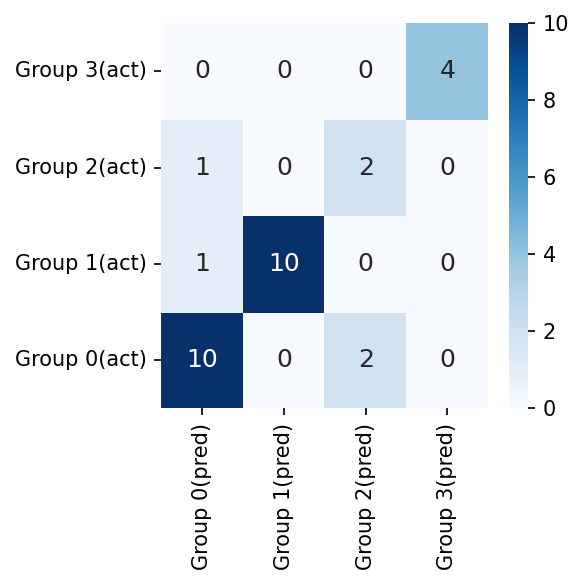

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# リストに変換
test_label = data.y[data.test_mask].tolist() 
pred_label = pred[data.test_mask].tolist()

labels = [0, 1, 2, 3]
re_labels = ['Group 0', 'Group 1', 'Group 2', 'Group 3']

#混同行列の作成
conf_mx = confusion_matrix(test_label, pred_label, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + '(act)' for x in re_labels], columns=[x + '(pred)' for x in re_labels])

#可視化
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
 
print(classification_report(test_label, pred_label, labels=labels, digits=3))